# Spectral Angle Mapper (SAM) hyperspectral data classification

In this notebook, you will train and apply a Spectral Angle Mapper classifier on hyperspectral data from Bílá Louka, Krkonoše mountains, Czechia. Please start by reading about the dataset and area of interest [here](../../data_usecases/usecase_grasses_krkonose.md).

- *Prerequisities* (This notebook can be run either online using Google Colab or on your local machine)
	- A Google account for accessing Google Colab ([link to notebook](https://drive.google.com/file/d/1TPZa1B09R5Mh0gdqpW-hE7VpNw4hpuxo/view?usp=sharing)). If running the exercise in Google Colab, please copy the notebook to your own Google Drive and follow the exercise, you don't need to download the dataset.
	
	or
	- A Python environment with the necessary libraries ([manual](../../software/software_python.md)). Download this notebook (click the download button in the top right corner of the page) and follow the exercise.

    - Downloaded data ([module4.zip/theme4_exercise_machine_learning](https://doi.org/10.5281/zenodo.10003574))
    The dataset consists of:
        + Hyperspectral RPAS imagery of Bílá Louka, Czechia (50.728N, 15.682E) acquired in August of 2020 and resampled to 54 spectral bands with ground sampling distance of 9 cm: *BL_202008_imagery.tif*
        + a raster with reference data: *BL_202008_reference.tif*
        + Pretrained models and corresponding classified rasters: _/sample_results/*_
         
- *Tasks*
    - Preprocess hyperspectral imagery
    - Classify the hyperspectral image using SAM
	- Observe how changing the training set size changes the resulting classification
	- Evaluate your results and compare to our pretrained classifier
    - *Optional:* Classify a urban scene

## Structure of this exercise

What are you going to encounter during this exercise.

0. Load libraries, set paths
1. Load and Preprocess training data
2. Extract mean spectral curves from training data
3. Apply Classifier
4. Evaluate Result
5. Sample Solution

## 0. Load external libraries and set paths

First, we need to import external libraries:

- __numpy__ - Arrays to hold our data
- __matplotlib.pyplot__ - Draw images


- __sklearn.metrics__ - Compute accuracy metrics using scikit-learn
- __sklearn.preprocessing__ - Normalizing input data using scikit-learn


- __time.perf_counter__ - Track how long individual functions take to run
- __os.path__ - Path manipulation
- __tqdm__ - show progress bars during training
- __joblib__ - Saving and loading trained classifiers


- __etrainee_m4_utils.hs_classification__ - Our library for using the SAM classifier - based on the pysptools package, which unfortunately no longer works
- __etrainee_m4_utils.image_preprocessing__ - Our library holding functions for image tiling, preprocessing, etc.
- __etrainee_m4_utils.inference_utils__ - Our library for correctly exporting classifed images
- __etrainee_m4_utils.visualisation_utils__ - Our library for visualising the data

Two external libraries are not imported directly in this notebook, but are used by functions in _image_preprocessing_ and _inference_utils_:

- __gdal__ - Manipulates spatial data
- __scipy.io__ - Reads .mat files

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter
from os.path import join

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from tqdm import notebook as tqdm
from joblib import dump, load

from etrainee_m4_utils.hs_classification import SAM_classifier
from etrainee_m4_utils import image_preprocessing
from etrainee_m4_utils import inference_utils
from etrainee_m4_utils import visualisation_utils

# GLOBAL SETTINGS
plt.rcParams['figure.figsize'] = [5, 5]
np.set_printoptions(precision=2, suppress=True)  # Array print precision

In [ ]:
# Set dataset name (used by visualisation functions) - 'bila_louka' or 'pavia_centre'
# default: 'pavia_centre'
ds_name = 'bila_louka'

# Get a list of class names
_, class_names = visualisation_utils._create_colorlist_classnames(ds_name=ds_name)

Please fill correct paths to your training and reference rasters (just pointing the _root_path_ variable to the project folder should do):

In [ ]:
root_path = 'C:/folder/where/this/project/is/saved'

# PATHS TO TRAINING DATA
# Bila Louka
imagery_path   = join(root_path, 'BL_202008_imagery.tif')
reference_path = join(root_path, 'BL_202008_reference.tif')
# Pavia
#imagery_path   = join(root_path, 'Pavia.mat')
#reference_path = join(root_path, 'Pavia_gt.mat')

# PATH TO SAVE CLASSIFIED IMAGE
out_path  = join(root_path, 'results/Krkonose_SAM.tif')

# PATH TO THE SAMPLE RESULTS
sample_result_path  = join(root_path, 'sample_results/SAM_sample_result.tif')

## 1. Load and preprocess training data

### 1.1. Data loading into NumPy
Let's start by reading an image into a numpy array, we do this in the background using GDAL.

The result of our function is a dictionary named loaded_raster, which contains two numpy arrays under keys _imagery_ and _reference_. As we can see, the loaded hyperspectral dataset has 1088 by 1088 pixels with 54 spectral bands. The raster containing our reference data has the same dimensions in height and width.

For loading most raster datasets, we created a _read_gdal()_ function in the _image_preprocessing_ module. But loading .mat files for the Pavia City Centre requires a specific function (_read_pavia_centre()_). Both _read_pavia_centre()_ and _read_gdal()_ return a dictionary containing two numpy arrays with keys _imagery_ and _reference_.

If using the Pavia City Centre dataset, you may notice that the original image has a shape of (1096, 1096, 102), but to make the data easier to tile for neural networks, we crop the image to (1088, 1088, 102) here.

In [ ]:
loaded_raster = image_preprocessing.read_gdal(imagery_path, reference_path)
#loaded_raster = image_preprocessing.read_pavia_centre(imagery_path,
    # reference_path, out_shape=(1088, 1088, 102))

print(f'Tiled imagery shape {loaded_raster["imagery"].shape}')
print(f'Tiled reference shape {loaded_raster["reference"].shape}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


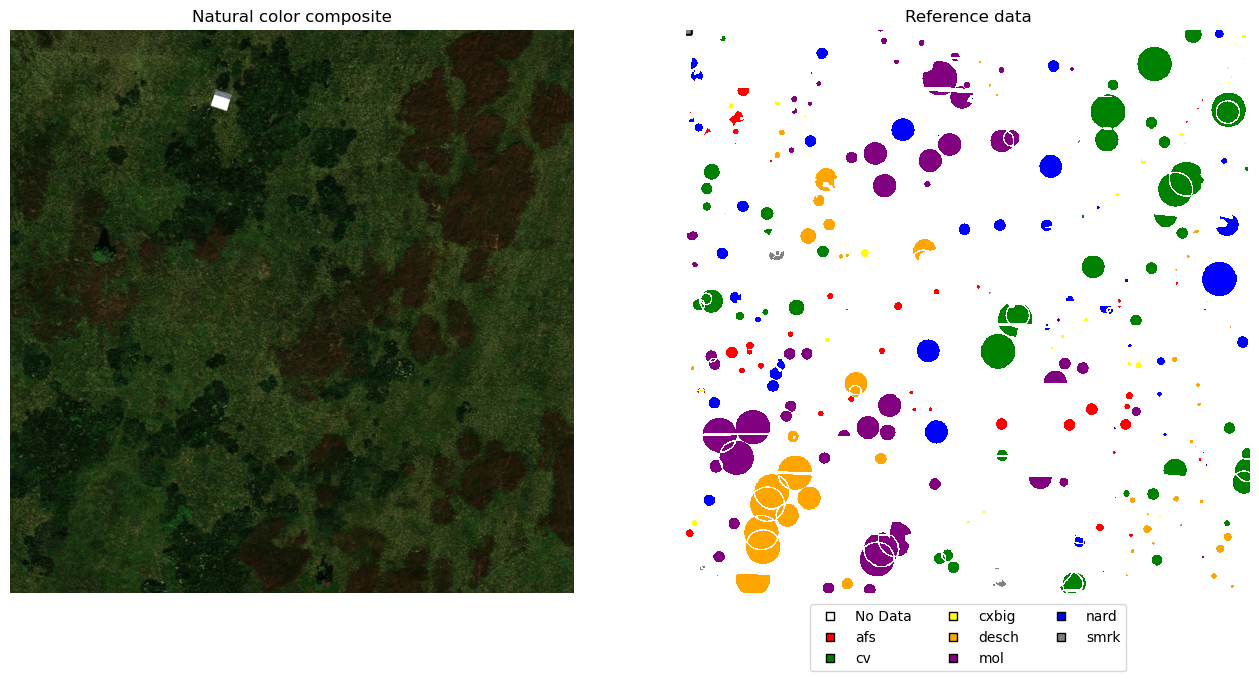

In [5]:
visualisation_utils.show_img_ref(loaded_raster["imagery"][:, :, [25, 15, 5]],
                                 loaded_raster["reference"], ds_name=ds_name)

### 1.2. Flatten array
We will be classifying individual pixels, therefore we can transform the 3D image (height, width, spectral bands) to a 2D array (length, spectral bands). This transformation destroys spatial relationships within the image, however the classifiers can only use 1D features anyway and it simplifies the next step (filtering NoData).

In [ ]:
orig_shape = loaded_raster['imagery'].shape

flat_arrs = {}
flat_arrs['imagery'] = loaded_raster['imagery'].reshape(
    orig_shape[0]*orig_shape[1], orig_shape[2])
flat_arrs['reference'] = loaded_raster['reference'].reshape(
    orig_shape[0]*orig_shape[1])

print(f'The flat imagery array has shape {flat_arrs["imagery"].shape}')

### 1.3. Filter out NoData pixels

We can only train the classifier on pixels with a reference value, therefore we remove all pixels belonging to class 0 (NoData). This operation reduces our training dataset from ~1.18 milion to ~130 thousand pixels. We then visualise the spectral curves of individual pixels.

In [ ]:
filtered_arrs = {}
filtered_arrs['imagery'] = flat_arrs['imagery'][flat_arrs['reference'] > 0]
filtered_arrs['reference'] = flat_arrs['reference'][flat_arrs['reference'] > 0]

print(f'The filtered array has shape {filtered_arrs["imagery"].shape}')

In [ ]:
pixel_number = 1000
visualisation_utils.show_spectral_curve(filtered_arrs, pixel_number,
                                        ds_name=ds_name)

### 1.4. Splitting data for training/testing
Our reference dataset has to be split into three groups:

*training / validation / test*

In this step we divide the data into train+val and test groups. The variable _train_fraction_ is used to establish how big of a fraction of the reference dataset is used for training and validation. By default, a third of the referece data is useed for training and validation, while the other two thirds are used for testing model preformance. The splitting is done using a scikit learn function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), which performs a stratified sampling from all classes.

Please experiment with different fractions of training data.

In [ ]:
train_fraction = 1/3

X_train, X_test, y_train, y_test = train_test_split(filtered_arrs['imagery'], filtered_arrs['reference'], train_size=train_fraction)


train = {'imagery': X_train, 'reference': y_train}
test  = {'imagery': X_test,  'reference': y_test}

In [ ]:
# How many training samples do we have for each class?
unique, counts = np.unique(train['reference'], return_counts=True)
print(f'The individual classes contain {counts} training pixels.')

## 2. Extract mean spectral curves from training data
The training data can then be used to extract mean spectral curves for each class, thus creating a spectral library. the spectral library is then used by the classifier.

In [ ]:
num_classes = np.unique(train['reference']).shape[0]
num_bands   = train['imagery'].shape[1]
mean_bands = np.empty((num_classes, num_bands))

for class_val in np.unique(train['reference']):
    mean_bands[class_val-1, :] = np.mean(train['imagery'][train['reference'] == class_val], axis=0)

spectral_lib = {'imagery': mean_bands, 'reference': np.unique(train['reference'])}

Let's visualise our spectral library

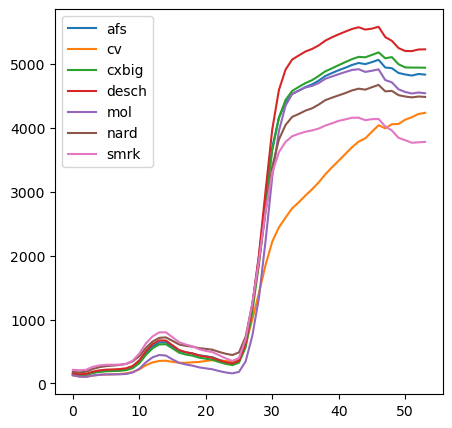

In [20]:
for cls in range(mean_bands.shape[0]):
    plt.plot(mean_bands[cls, :], label=class_names[cls+1])
plt.legend()

## 3. Model application & evaluation

### 3.1. Loading and preprocessing the data

Load a raster to classify. This can be the one that we used for training, but it can also be a different raster with the same number of bands.

By default, the training raster (_imagery_path_) is used.

In [ ]:
# Load raster
raster = image_preprocessing.read_gdal_with_geoinfo(imagery_path, (0,0))

# Flattern spatial dimension of the raster
raster_shape = raster['imagery'].shape
raster_flat = raster['imagery'].reshape(raster_shape[0]*raster_shape[1],
                                        raster_shape[2])

### 3.2. Defining and applying the classifier

The following snippet applies the classifier to the loaded imagery, and then transforms the flattened array back into a raster.

In [ ]:
predicted_flat = SAM_classifier(raster_flat, mean_bands, threshold=0.9)

In [ ]:
predicted_raster = predicted_flat.reshape(raster_shape[0], raster_shape[1])

You can also visualise the result:

In [ ]:
visualisation_utils.show_classified(loaded_raster['imagery'][:, :, [25, 15, 5]],
                                    loaded_raster['reference'],
                                    predicted_raster, ds_name=ds_name)

### 3.3. Export resulting raster

Export the resulting classified raster into _out_path_ for distribution or further analysis (e.g. validation in GIS).

In [ ]:
inference_utils.export_result(out_path, predicted_raster, raster['geoinfo'])

## 4. Evaluate Classification Result

### 4.1. Apply classifier to the test dastaset

In [ ]:
classified_test = SAM_classifier(test['imagery'], mean_bands, threshold=0.9)

### 4.2. Compute accuracy metrics

In [ ]:
print(classification_report(test['reference'], classified_test,
      target_names=class_names[1:]))

### 4.3. Show Confusion Matrix

In [ ]:
visualisation_utils.show_confusion_matrix(test['reference'], classified_test,
                                          ds_name=ds_name)

## 5. Sample Solution

Our classification has generated this result (please note that you may get a different result):

In [ ]:
# Read test reference
test_arr = image_preprocessing.read_gdal(imagery_path, reference_path)
test_flat = test_arr['reference'].reshape(
    test_arr['reference'].shape[0]*test_arr['reference'].shape[1])
test_filtered = test_flat[test_flat > 0]

# Read sample result
sample_arr = image_preprocessing.read_gdal(imagery_path, sample_result_path)
sample_flat = sample_arr['reference'].reshape(
    sample_arr['reference'].shape[0] * sample_arr['reference'].shape[1])
sample_filtered = sample_flat[test_flat > 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


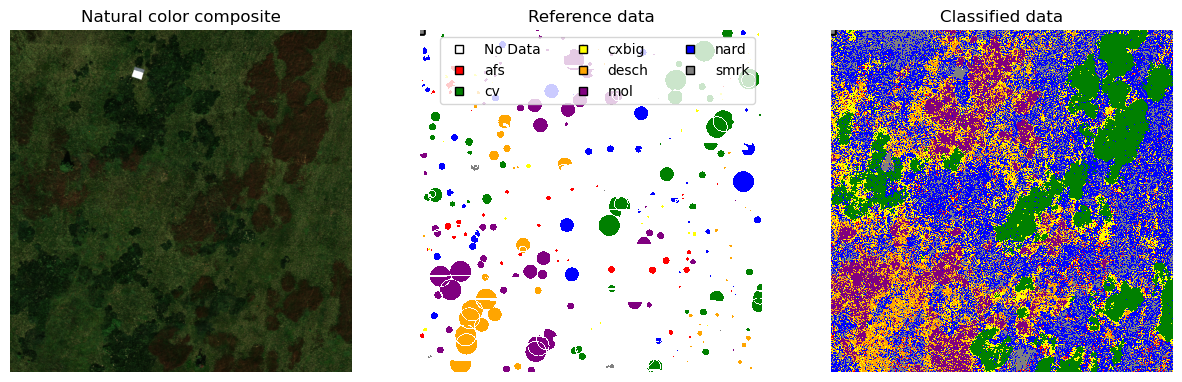

In [11]:
# Visualise the sample result
visualisation_utils.show_classified(loaded_raster['imagery'][:, :, [25, 15, 5]],
                                    loaded_raster['reference'],
                                    sample_arr['reference'],
                                    ds_name=ds_name)

In [12]:
# Print a classification report for the sample result
print(classification_report(test_filtered, sample_filtered,
      target_names=class_names[1:]))

              precision    recall  f1-score   support

         afs       0.29      0.13      0.18      4937
          cv       0.99      0.94      0.96     39342
       cxbig       0.04      0.38      0.07      1002
       desch       0.49      0.43      0.46     24423
         mol       0.97      0.62      0.75     40227
        nard       0.47      0.58      0.52     18456
        smrk       0.04      0.75      0.08       579

    accuracy                           0.65    128966
   macro avg       0.47      0.55      0.43    128966
weighted avg       0.78      0.65      0.70    128966



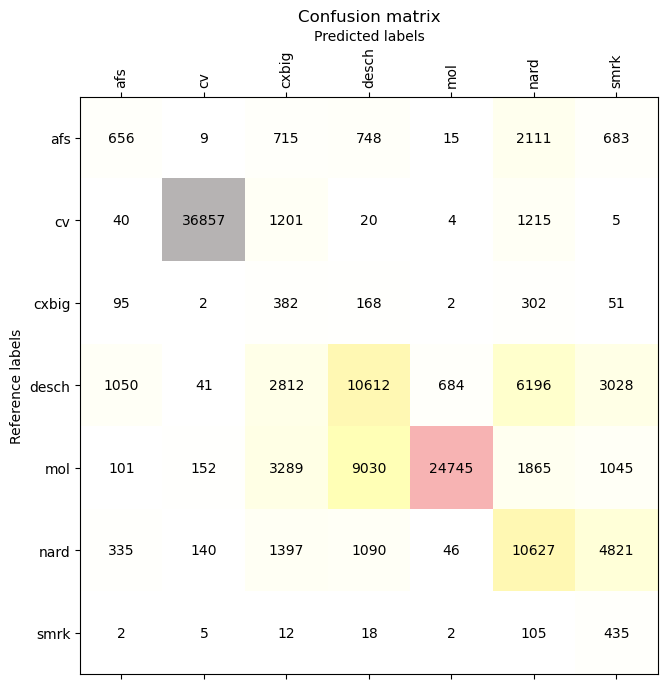

In [13]:
# Show a Confusion matrix for the sample result
visualisation_utils.show_confusion_matrix(test_filtered, sample_filtered,
                                          ds_name=ds_name)

## *Optional:* Classify a urban scene

Try using this notebook to classify a urban scene (Pavia City Centre). Reflect on how the different landscape structure and clearer class definitions influence the classification result.

Pavia city centre is a common benchmark for hyperspectral data classification and can be obtained from [http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Pavia_Centre_and_University](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Pavia_Centre_and_University). You will need to change the paths to input data and use the *read_pavia_centre* method to load the matlab matrices into numpy.

Return to [exercises](04_time_series_specifics_exercise.md)